In [ ]:
!pip install pandas
!pip install shap
!pip install category_encoders
!pip install xgboost
#pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cpu
#!pip install transformers 
#!pip install tensorflow

In [2]:
import pandas as pd
import IPython
import shap
import numpy as np
import category_encoders as ce
import random
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from IPython.display import FileLink, HTML

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#import dataset
data = pd.read_excel("C:/Users/HP/Downloads/data.xlsx")
#data = pd.read_excel("path/to/data.xlsx")

In [ ]:
# data.to_excel('data.xlsx', index=False)
# IPython.display.FileLink('data.xlsx')

In [ ]:
# Reduced the dimensionality of the original dataset from 2397 feature columns to 27 features and 7833 instances after data preprocessing 
# (feature selection, filtering, standardization, imputation, and encoding). 

In [49]:
# Training features include-

# Confidence (High, Low, Medium)
# Incident (Confirmed, Suspected)
# Targeted (Opportunistic, Targeted, Unknown)
# Actor (External, Internal, Partner, Unknown)
# Asset variety (Server, Network, UserDev, Media, Person, Kiosk/Term, Unknown, Embedded, Cloud)
# Attribute (Confidentiality, Integrity, Availability)
# Size (Small, Large)
# Employee Count (below10k, above10k)
# Pattern (Point of Sale, Web Applications, Privilege Misuse, Lost and Stolen Assets, Miscellaneous Errors, Crimeware, Payment Card Skimmers, 
#          Denial of Service, Cyber-Espionage, Everything Else)
# Discovery Method (external, internal, partner, other)
# Industry (92,62,51,22,81,52,61,44,48,54,72,56,42,31,71,53,55,23,21,11)
    
# 11	Agriculture, Forestry, Fishing and Hunting
# 21	Mining, Quarrying, and Oil and Gas Extraction
# 22	Utilities
# 23	Construction
# 31	Manufacturing
# 42	Wholesale Trade
# 44	Retail Trade
# 48	Transportation and Warehousing
# 51	Information
# 52	Finance and Insurance
# 53	Real Estate and Rental and Leasing
# 54	Professional, Scientific, and Technical Services
# 55	Management of Companies and Enterprises
# 56	Administrative and Support and Waste Management and Remediation Services
# 61	Educational Services
# 62	Health Care and Social Assistance
# 71	Arts, Entertainment, and Recreation
# 72	Accommodation and Food Services
# 81	Other Services (except Public Administration)
# 92	Public Administration 
 
# impact.overall_amount - Estimate of total losses attributed to this incident in USD
# victim.locations_affected - No. of victim locations/branches affected
# victim.secondary.amount - No. of secondary victims (such as in supply chain attack)
# timeline.compromise/containment/discovery/exfiltration.days - Total time until compromise/containment/discovery/exfiltration in days
# asset.total_amount - Total number of assets compromised
# asset.amount.M/N/P/S/T/U/Unknown - Total number of assets compromised under each Asset variety

# Target feature is Action with 8 classes - malware, hacking, socialengineering, physical, misuse, error, environmental, unknown

In [4]:
data.shape

(7833, 27)

In [5]:
data.columns

Index(['Confidence', 'Incident', 'Targeted', 'Actor', 'Action', 'Asset',
       'Attribute', 'Size', 'Industry', 'Pattern', 'Employee Count',
       'Discovery Method', 'Assets (total)', 'Impact', 'Victim Locations',
       'Secondary Victims', 'Compromise', 'Containment', 'Discovery',
       'Exfiltration', 'Assets (M)', 'Assets (N)', 'Assets (P)', 'Assets (S)',
       'Assets (T)', 'Assets (U)', 'Assets (unknown)'],
      dtype='object')

In [35]:
data.head()

,Confidence,Incident,Targeted,Actor,Action,Asset,Attribute,Size,Industry,Pattern,...,Containment,Discovery,Exfiltration,Assets (M),Assets (N),Assets (P),Assets (S),Assets (T),Assets (U),Assets (unknown)
0,0,0,0,1,4,0,0,1,0,2,...,-0.018262,-0.117746,-0.016269,-0.014115,-0.022604,-0.040357,-0.029921,-0.064803,-0.02898,-0.012387
1,0,0,0,0,3,2,0,0,1,3,...,-0.018262,-0.117746,-0.016269,-0.014115,-0.022604,-0.040357,-0.029921,-0.064803,-0.02898,-0.012387
2,0,0,0,2,5,3,0,1,1,3,...,-0.018262,-0.117746,-0.016269,-0.014115,-0.022604,-0.040357,-0.029921,-0.064803,-0.02898,-0.012387
3,0,0,0,0,1,0,0,0,2,1,...,-0.018262,-0.117746,-0.016269,-0.014115,-0.022604,-0.040357,-0.029921,-0.064803,-0.02898,-0.012387
4,0,0,0,1,5,3,0,1,0,4,...,-0.018262,-0.117746,-0.016269,-0.014115,-0.022604,-0.040357,-0.029921,-0.064803,-0.02898,-0.012387


In [32]:
#split data into train and test sets
target_columns = [col for col in data.columns if 'Action' in col]
feature_columns = [col for col in data.columns if col not in target_columns]
X = data[feature_columns]
y = data[target_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
warnings.filterwarnings('ignore')

# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=8),
    "SVM": SVC(decision_function_shape='ovo'),
    "K-Nearest Neighbours": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=200, solver='lbfgs')
}

# Perform cross-validation and compare models
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[model_name] = scores.mean()

# Print the average cross-validation scores for each model
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.2f}")


Random Forest: 0.92
XGBoost: 0.93
SVM: 0.88
K-Nearest Neighbors: 0.88
Logistic Regression: 0.80


In [34]:
# Creating sample weights
flat_y_train = np.array(y_train).flatten()

class_counts = np.bincount(flat_y_train)
total_samples = len(flat_y_train)
class_weights = {i: total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))}

sample_weights = np.array([class_weights[y] for y in flat_y_train])

In [35]:
# Initialising the classification model
model = XGBClassifier(
    objective='multi:softmax', 
    num_class=8,
    reg_lambda=20,   
    gamma=1,   
)

# Training the classification model
model.fit(X_train,y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=8,
              num_parallel_tree=None, ...)

In [36]:
#test model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9081046585832802
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       126
           1       0.90      0.84      0.87       319
           2       0.45      0.58      0.51        43
           3       0.99      0.87      0.93       294
           4       0.96      0.96      0.96       331
           5       0.96      1.00      0.98       415
           6       0.40      1.00      0.57         2
           7       0.42      0.84      0.56        37

    accuracy                           0.91      1567
   macro avg       0.75      0.87      0.78      1567
weighted avg       0.93      0.91      0.91      1567



In [11]:
# Create shap explainer object
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Merge shap values based on predicted values
preds = model.predict(X_test)

new_shap_values = []
for i, pred in enumerate(preds):
  new_shap_values.append(shap_values.values[i][:, pred])

shap_values.values = np.array(new_shap_values)

(1567, 26)


In [25]:
# use this to see individual predictions of the trained model on a random data smaple
random_index = random.randint(0, X_test.shape[0] - 1)
X_sample = X_test.iloc[[random_index]]
y_sample_actual = y_test.iloc[[random_index]]

y_sample_pred = model.predict(X_sample)

print("Features:")
print(X_sample)
print("\nPredicted value:")
print(y_sample_pred)
print("\nActual value:")
print(y_sample_actual)

Features:
      Confidence  Incident  Targeted  Actor  Asset  Attribute  Size  Industry  \
5207           0         0         0      1      3          0     1         0   

      Pattern  Employee Count  ...  timeline.containment.days  \
5207        4               1  ...                  -0.018262   

      timeline.discovery.days  timeline.exfiltration.days  asset.amount.M  \
5207                -0.117746                   -0.016269       -0.014115   

      asset.amount.N  asset.amount.P  asset.amount.S  asset.amount.T  \
5207       -0.022604       -0.040357       -0.029921       -0.064803   

      asset.amount.U  asset.amount.Unknown  
5207        -0.02898             -0.012387  

[1 rows x 26 columns]

Predicted value:
[5]

Actual value:
      Action
5207       5


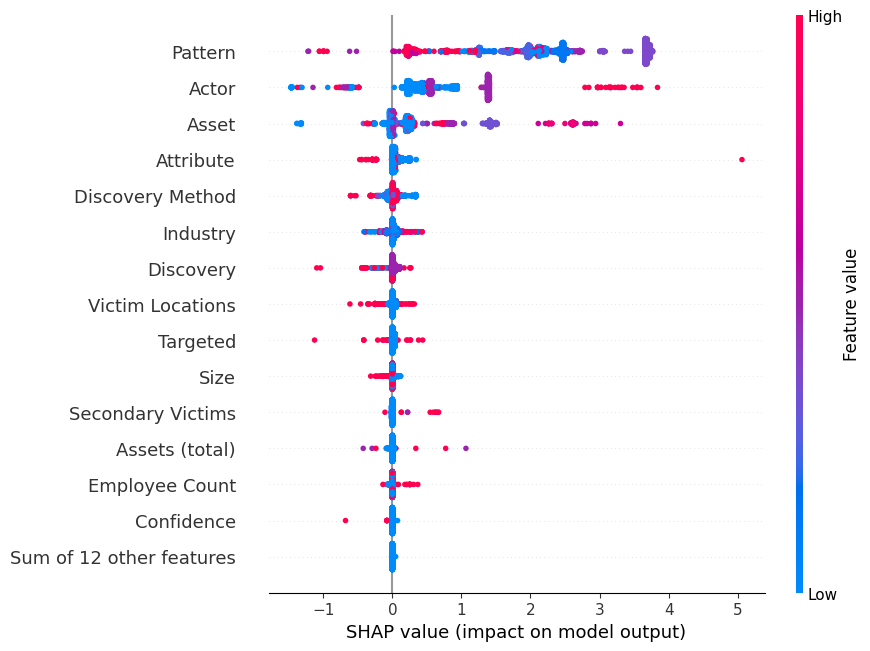

In [12]:
#plot shows which features have the greatest influence on model predictions 
shap.plots.beeswarm(shap_values, max_display = 15)

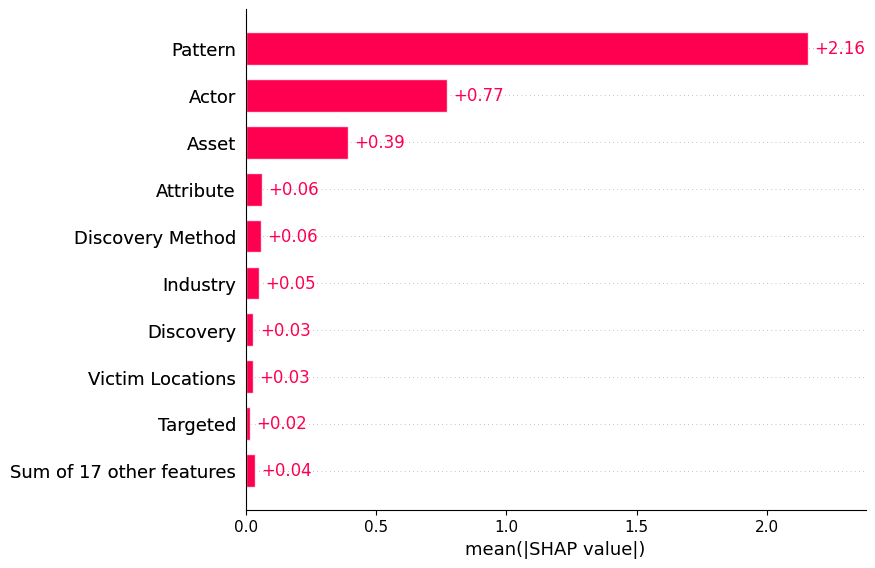

In [13]:
#plot showing mean shap values for each feature
shap.plots.bar(shap_values)

In [53]:

# Assuming your DataFrame is named df and the column of interest is named 'column_name'
value_counts = data['Action'].value_counts()

# To ensure that all values from 0 to 7 are represented, even if some are missing:
all_values = pd.Series(range(8))
value_counts = value_counts.reindex(all_values)

print(value_counts)


0     633
1    1707
2     181
3    1482
4    1452
5    2161
6       7
7     210
Name: count, dtype: int64


In [1]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
preds = model.predict(X_test)

In [23]:
cm = confusion_matrix(y_test, preds)
class_names = ['malware', 'hacking', 'social engineering', 'physical', 'misuse', 'error', 'environmental', 'unknown']

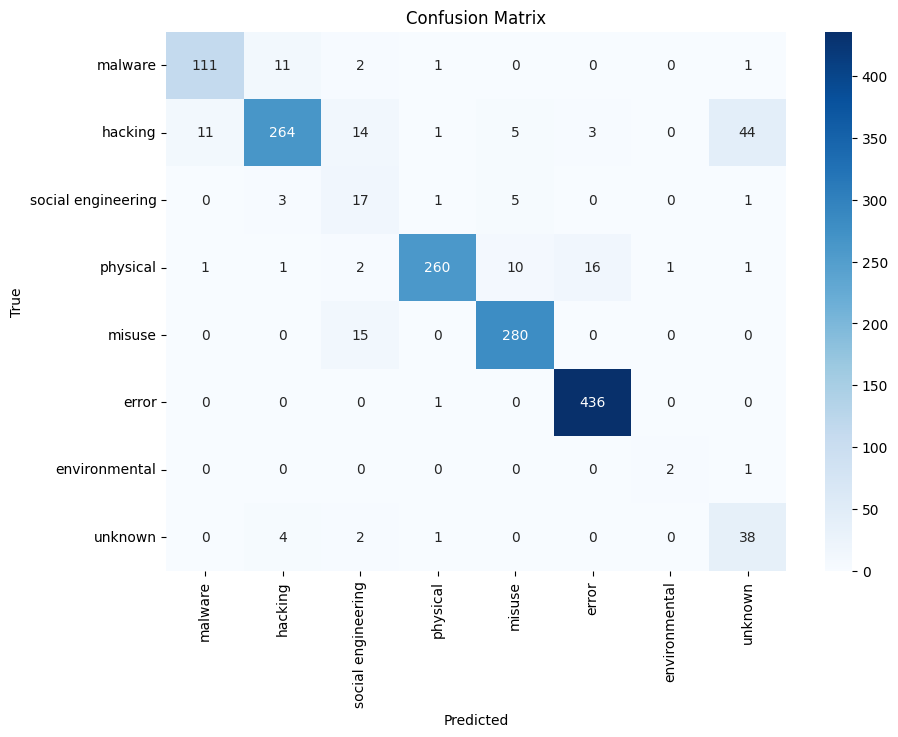

In [24]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
